In [202]:
import os
from time import sleep
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras import regularizers

from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import seaborn as sns


In [203]:
# base_path = '/Users/nicholastey/Desktop/thesis/gnss_spoof_detector/spoof_detector/data/'
base_path = 'C:/Users/nicho/Desktop/gnss_spoof_detector/spoof_detector/data'

In [150]:
cs_path, ds1_path, ds3_path, ds2_path, ds4_path, ds7_path, ds8_path = [os.path.join(base_path, ds_path) for ds_path in os.listdir(base_path)]

In [204]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [213]:
big_df = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df = dataset[prn].copy()
        df['spoofed'] = label
        df['prn'] = prn
        big_df.append(df)

big_df = pd.concat(big_df, ignore_index=True)
print(big_df.shape)
print(big_df.columns)
print(big_df['spoofed'].value_counts(normalize=True))

big_df

(189272, 12)
Index(['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs',
       'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'pseudorange_m', 'rx_time', 'spoofed'],
      dtype='object')
spoofed
5    0.146963
6    0.146963
1    0.145272
4    0.143920
2    0.142060
3    0.138002
0    0.136819
Name: proportion, dtype: float64


,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


In [ ]:
big_df.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)
big_df
print(big_df.shape)
print(big_df.columns)
print(big_df.isna().sum())


(189272, 7)
Index(['prn', 'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz',
       'rx_time', 'spoofed'],
      dtype='object')
prn                   0
prompt_i              0
prompt_q              0
cn0_db_hz             0
carrier_doppler_hz    0
rx_time               0
spoofed               0
dtype: int64


KeyError: "['cn0_db_hz_roll_mean', 'cn0_db_hz_roll_std'] not in index"

In [ ]:
# Sort by PRN and rx_time (in case it's not already)
big_df = big_df.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
window_size = 50

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'{col}_roll_mean'] = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df[f'{col}_roll_std']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df[f'{col}_roll_min']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df[f'{col}_roll_max']  = big_df.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'cn0_db_hz_roll_mean', 'cn0_db_hz_roll_std', 'cn0_db_hz_roll_min', 'cn0_db_hz_roll_max', 'carrier_doppler_hz_roll_mean', 'carrier_doppler_hz_roll_std', 'carrier_doppler_hz_roll_min', 'carrier_doppler_hz_roll_max']].head()



,prn,cn0_db_hz,carrier_doppler_hz,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max
6474,3,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0
6475,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [198]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df[f'delta_{col}'] = big_df.groupby('prn')[col].diff().fillna(0)

big_df[['prn', 'cn0_db_hz', 'carrier_doppler_hz', 'delta_cn0_db_hz', 'delta_carrier_doppler_hz']].head()



,prn,cn0_db_hz,carrier_doppler_hz,delta_cn0_db_hz,delta_carrier_doppler_hz
6474,3,0.0,0.0,0.0,0.0
6475,3,0.0,0.0,0.0,0.0
6476,3,0.0,0.0,0.0,0.0
6477,3,0.0,0.0,0.0,0.0
6478,3,0.0,0.0,0.0,0.0


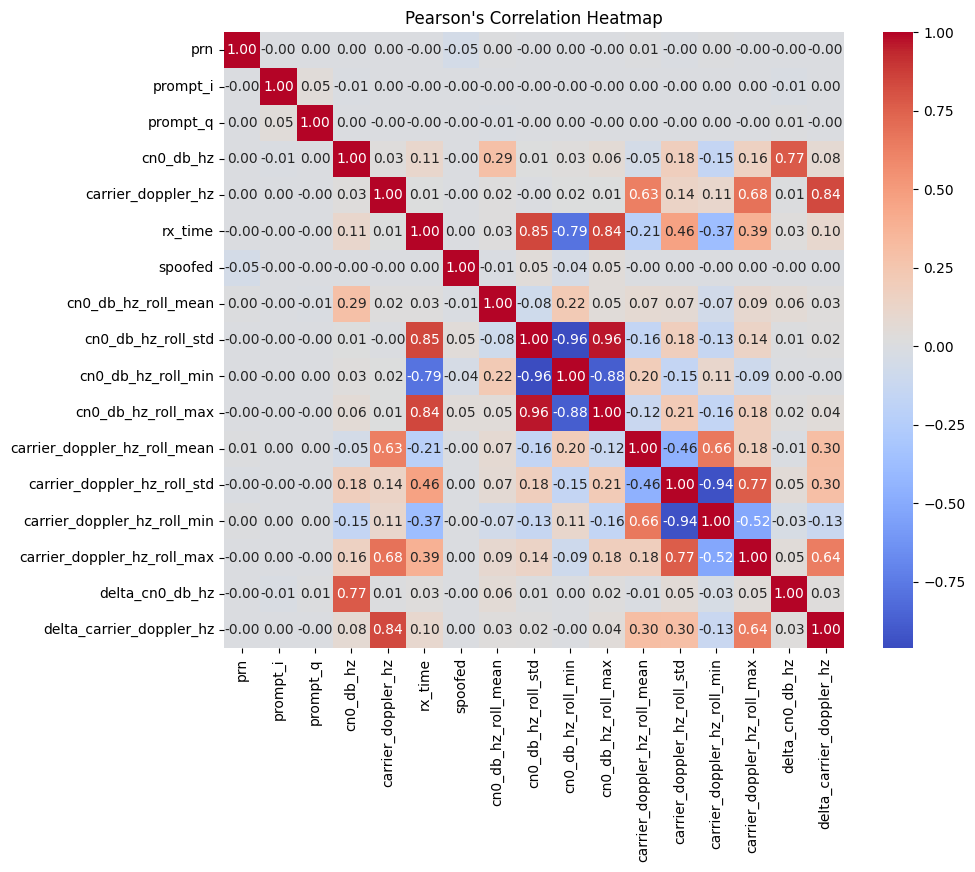

In [156]:
# Compute the correlation matrix
correlation_matrix = big_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [157]:
columns = ['channel', 'prn', 'acq_doopler_hz', 'acq_doppler_step', 'fs', 
           'prompt_i', 'prompt_q', 'cn0_db_hz', 'carrier_doppler_hz', 
           'pseudorange_m', 'rx_time']

for ds_fname in os.listdir(base_path):
    tmp_path = os.path.join(base_path, ds_fname)
    key = ds_fname.split('.')[0]
    
    tmp_df = pd.read_csv(tmp_path, header=None)
    prn_li = []
    
    for i in range(8):
        prn_li.append(int(tmp_df.iloc[1, 11*i+1]))

    globals()[f'{key}_dict'] = {
        int(f'{prn_li[0]}') : tmp_df.iloc[100:, 0:11].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[1]}') : tmp_df.iloc[100:, 11:22].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[2]}') : tmp_df.iloc[100:, 22:33].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[3]}') : tmp_df.iloc[100:, 33:44].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[4]}') : tmp_df.iloc[100:, 44:55].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[5]}') : tmp_df.iloc[100:, 55:66].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[6]}') : tmp_df.iloc[100:, 66:77].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        int(f'{prn_li[7]}') : tmp_df.iloc[100:, 77:88].rename(columns=lambda x: columns[x%11]).diff().fillna(0),
        'prn' : prn_li
    }


In [158]:
big_df_no_diff = []

dicts_with_labels = [
    (cs_dict, 0),  # Clean
    (ds1_dict, 1),
    (ds2_dict, 2),
    (ds3_dict, 3),
    (ds4_dict, 4),
    (ds7_dict, 5),
    (ds8_dict, 6)
]

for dataset, label in dicts_with_labels:
    for prn in dataset['prn']:
        df_no_diff = dataset[prn].copy()
        df_no_diff['spoofed'] = label
        df_no_diff['prn'] = prn
        big_df_no_diff.append(df_no_diff)

big_df_no_diff = pd.concat(big_df_no_diff, ignore_index=True)
big_df_no_diff

,channel,prn,acq_doopler_hz,acq_doppler_step,fs,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,pseudorange_m,rx_time,spoofed
0,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
1,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
2,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
3,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
4,0.0,13,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
189267,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189268,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189269,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6
189270,0.0,16,0.0,0.0,0.0,0.0,0.0000,0.000000,0.00000,0.000000,0.0,6


In [159]:
big_df_no_diff.drop(columns=['channel', 'fs', 'acq_doppler_step', 'pseudorange_m', 'acq_doopler_hz'], inplace=True)

In [160]:
# Calculate magnitude and phase
big_df['prompt_magnitude'] = np.sqrt(big_df['prompt_i']**2 + big_df['prompt_q']**2)
big_df['prompt_phase'] = np.arctan2(big_df['prompt_q'], big_df['prompt_i'])

# Calculate deltas (first-order difference)
big_df['delta_prompt_magnitude'] = big_df['prompt_magnitude'].diff().fillna(0)
big_df['delta_prompt_phase'] = big_df['prompt_phase'].diff().fillna(0)


In [161]:
# Calculate magnitude and phase
big_df_no_diff['prompt_magnitude'] = np.sqrt(big_df_no_diff['prompt_i']**2 + big_df_no_diff['prompt_q']**2)
big_df_no_diff['prompt_phase'] = np.arctan2(big_df_no_diff['prompt_q'], big_df_no_diff['prompt_i'])

# Calculate deltas (first-order difference)
big_df_no_diff['delta_prompt_magnitude'] = big_df_no_diff['prompt_magnitude'].diff().fillna(0)
big_df_no_diff['delta_prompt_phase'] = big_df_no_diff['prompt_phase'].diff().fillna(0)

In [ ]:
# Sort by PRN and rx_time (in case it's not already)
big_df_no_diff = big_df_no_diff.sort_values(by=['prn', 'rx_time'])

# Define a rolling window size
window_size = 50

# Apply rolling stats grouped by PRN
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'{col}_roll_mean'] = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    big_df_no_diff[f'{col}_roll_std']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).std())
    big_df_no_diff[f'{col}_roll_min']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).min())
    big_df_no_diff[f'{col}_roll_max']  = big_df_no_diff.groupby('prn')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).max())

In [163]:
for col in ['cn0_db_hz', 'carrier_doppler_hz']:
    big_df_no_diff[f'delta_{col}'] = big_df_no_diff.groupby('prn')[col].diff().fillna(0)


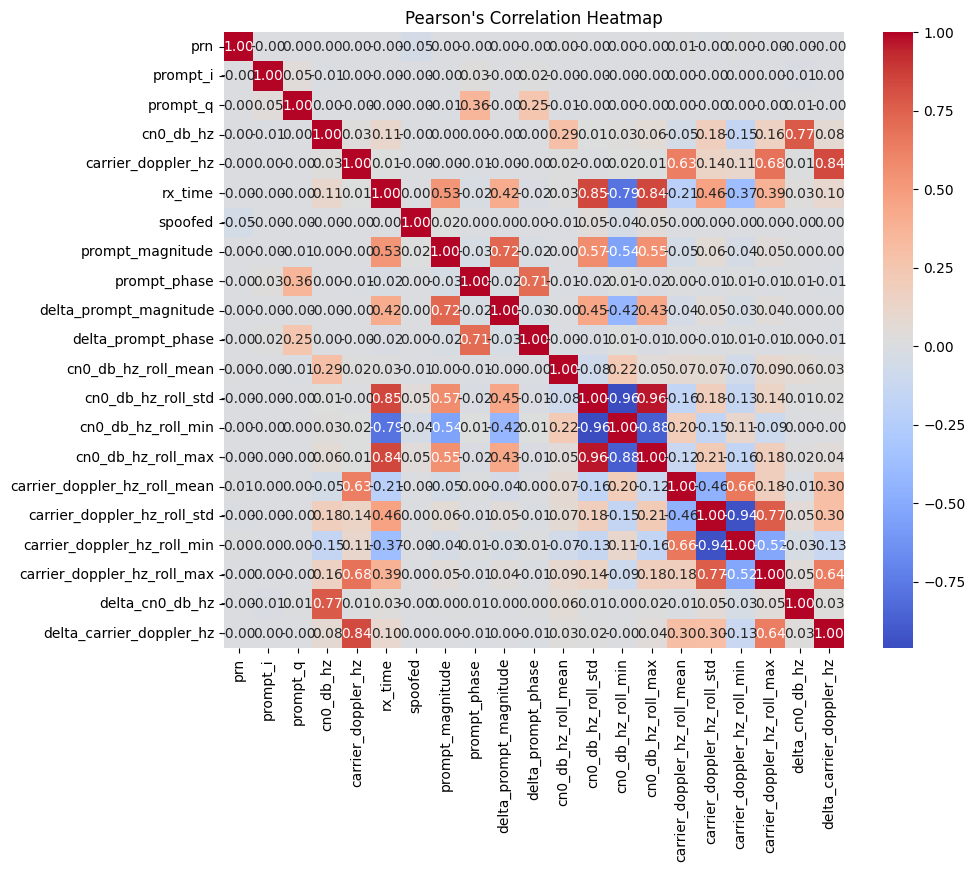

In [164]:
# Compute the correlation matrix
correlation_matrix_no_diff = big_df_no_diff.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_no_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Pearson's Correlation Heatmap")
plt.show()

In [165]:
big_df_no_diff.drop(columns=['prn'], inplace=True)
big_df.drop(columns=['prn'], inplace=True)

In [166]:
#scale data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(big_df.drop('spoofed', axis=1))

scaled_df = pd.DataFrame(scaled_df, columns=big_df.drop('spoofed', axis=1).columns)
scaled_df['spoofed'] = big_df['spoofed'].values


In [167]:
#scale data
scaler = StandardScaler()
scaled_df_no_diff = scaler.fit_transform(big_df_no_diff.drop('spoofed', axis=1))

scaled_df_no_diff = pd.DataFrame(scaled_df_no_diff, columns=big_df_no_diff.drop('spoofed', axis=1).columns)
scaled_df_no_diff['spoofed'] = big_df_no_diff['spoofed'].values

In [168]:
scaled_df.dropna(inplace=True)
scaled_df_no_diff.dropna(inplace=True)

In [169]:
# SVM with diff
X = scaled_df.drop(columns=['spoofed'])
y = scaled_df['spoofed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

X_no_diff = scaled_df_no_diff.drop(columns=['spoofed'])
y_no_diff = scaled_df_no_diff['spoofed']

X_train_no_diff, X_test_no_diff, y_train_no_diff, y_test_no_diff = train_test_split(X_no_diff, y_no_diff, test_size=0.2, shuffle=True)
X_train_no_diff, X_val_no_diff, y_train_no_diff, y_val_no_diff = train_test_split(X_train_no_diff, y_train_no_diff, test_size=0.2, shuffle=True)    

In [170]:
X_train

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase
26281,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014
57680,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014
181180,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014
157354,-2.033297,0.320973,-3.815550,-0.163346,2.356523,3.469182,2.777697,-1.866355,3.495740,-0.273330,0.533697,-0.287263,0.470423,-6.024661,-0.186015,1.859336,4.333768,2.051877e+00,5.263391
89206,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45183,0.185623,-0.200346,2.183440,0.067854,2.356523,0.766180,1.133559,-1.475775,0.948204,-0.398129,0.229786,-0.187292,0.150057,3.507985,0.259395,-0.033442,-0.027535,-6.652089e-03,2.848450
5030,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014
11050,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014
24358,-0.000022,0.000140,0.001484,0.002573,-0.336665,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424,-0.223683,0.005568,-1.679969e-07,-0.000014


In [171]:
X_train_no_diff

,prompt_i,prompt_q,cn0_db_hz,carrier_doppler_hz,rx_time,prompt_magnitude,prompt_phase,delta_prompt_magnitude,delta_prompt_phase,cn0_db_hz_roll_mean,cn0_db_hz_roll_std,cn0_db_hz_roll_min,cn0_db_hz_roll_max,carrier_doppler_hz_roll_mean,carrier_doppler_hz_roll_std,carrier_doppler_hz_roll_min,carrier_doppler_hz_roll_max,delta_cn0_db_hz,delta_carrier_doppler_hz
179984,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424
71789,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424
151699,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424
8654,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424
7336,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68196,4.458048,-0.186951,-0.820194,0.070807,2.356523,4.343427,0.004281,3.151632,-9.097904e-04,0.896124,2.898064,-2.712494,4.760746,0.118368,0.156045,-0.070505,0.218914,-1.909176,0.092417
99796,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-1.648176,-3.063465e+00,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424
3527,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424
28210,-0.000022,0.000140,0.001484,0.002573,-0.336665,-0.223683,0.005568,-0.000018,-2.213183e-08,0.018996,-0.343151,0.330164,-0.329136,0.039116,-0.048012,0.031745,-0.037940,-0.000618,-0.001424


In [172]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

spoofed
6    0.147680
5    0.146194
1    0.145162
4    0.144543
2    0.141422
3    0.137872
0    0.137129
Name: proportion, dtype: float64
spoofed
1    0.145959
5    0.145880
6    0.145801
4    0.142816
2    0.142736
3    0.139091
0    0.137717
Name: proportion, dtype: float64


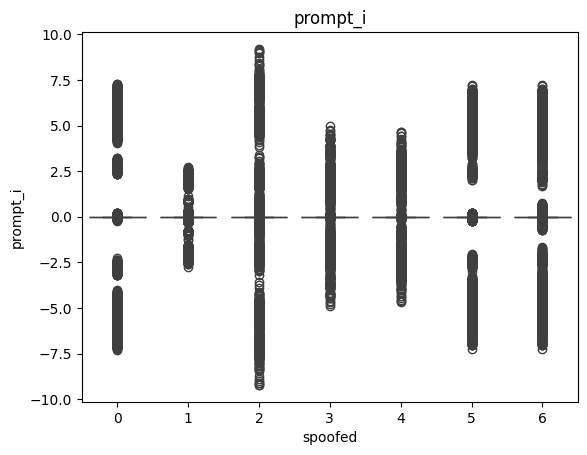

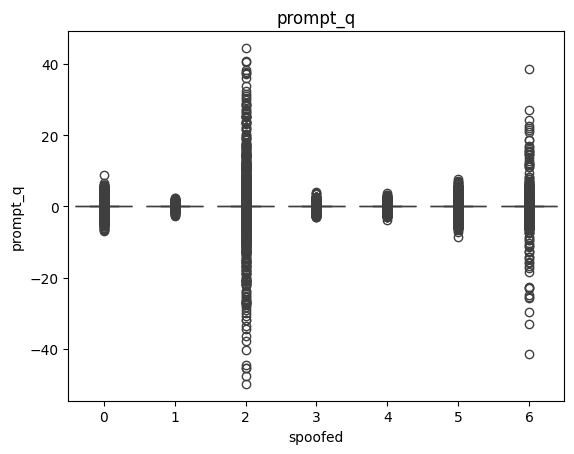

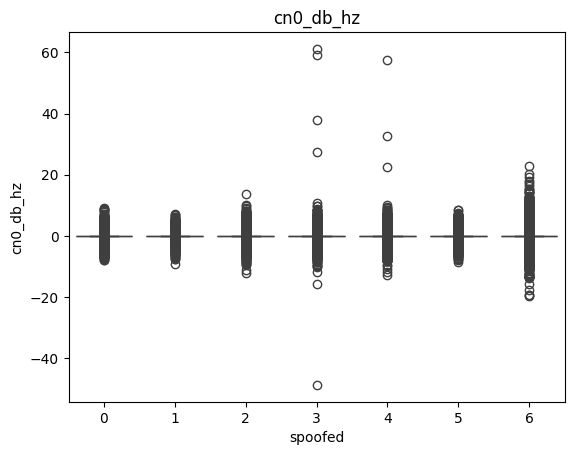

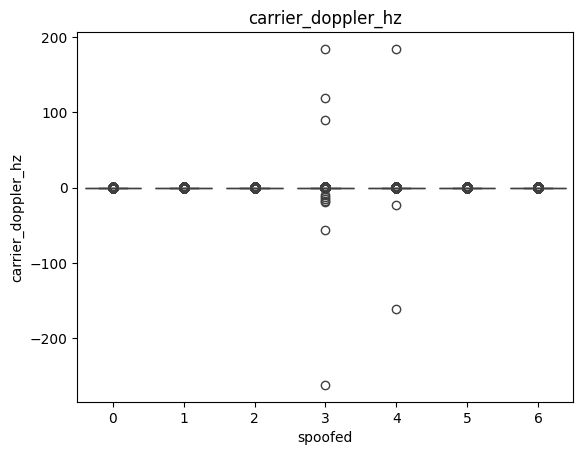

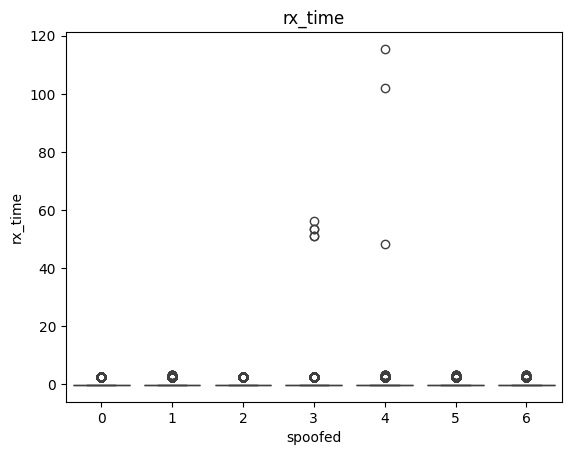

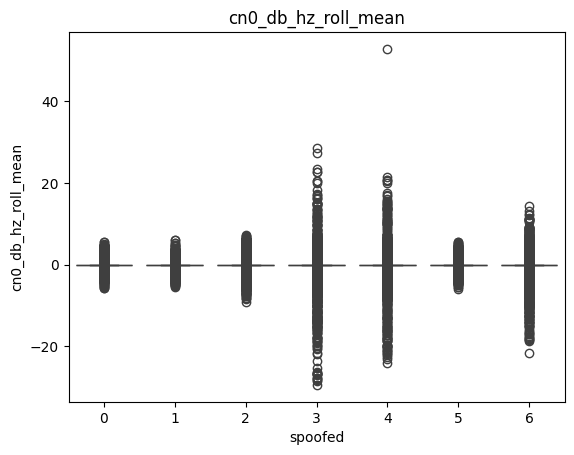

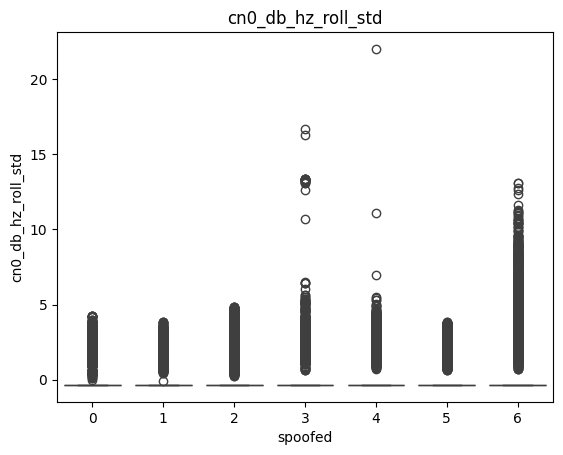

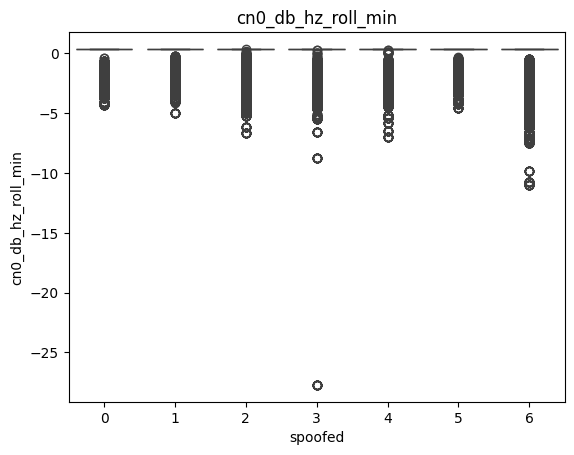

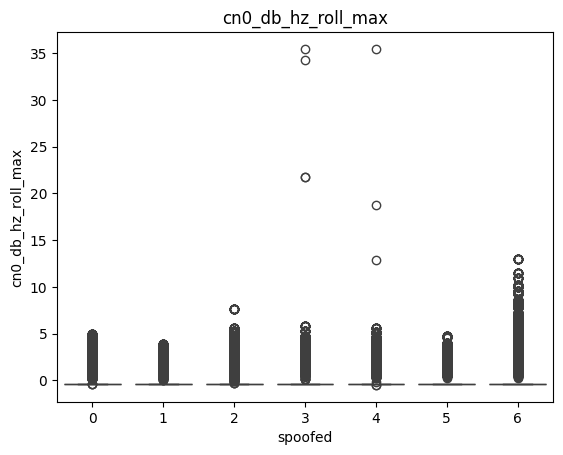

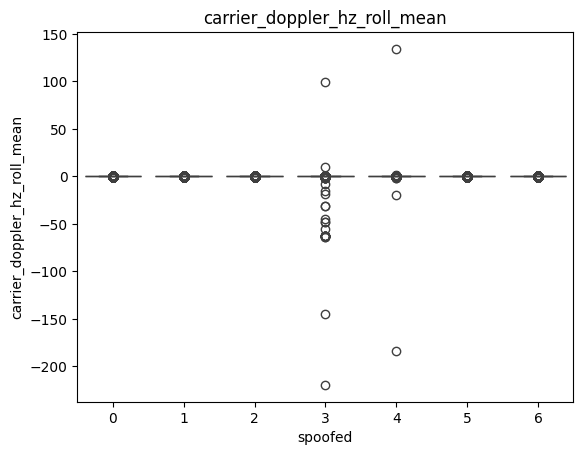

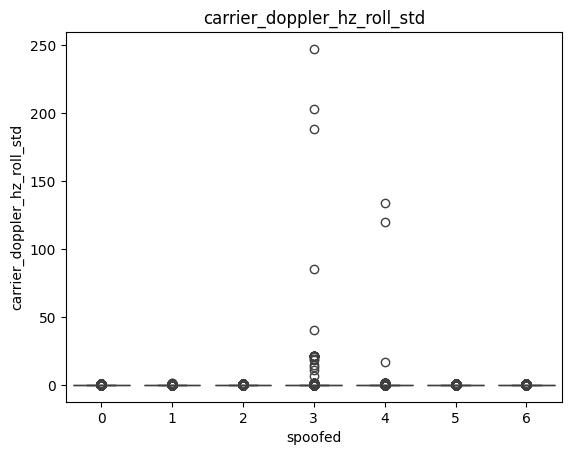

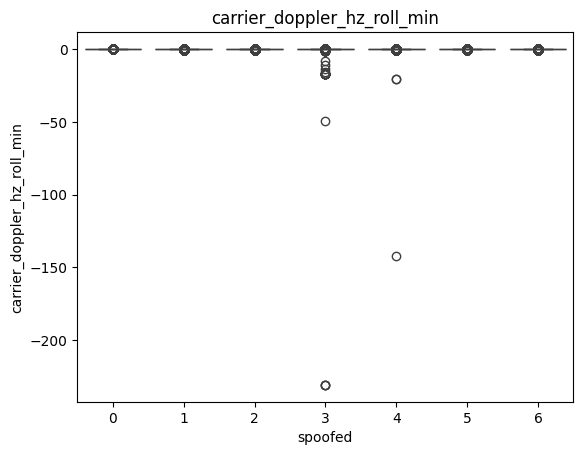

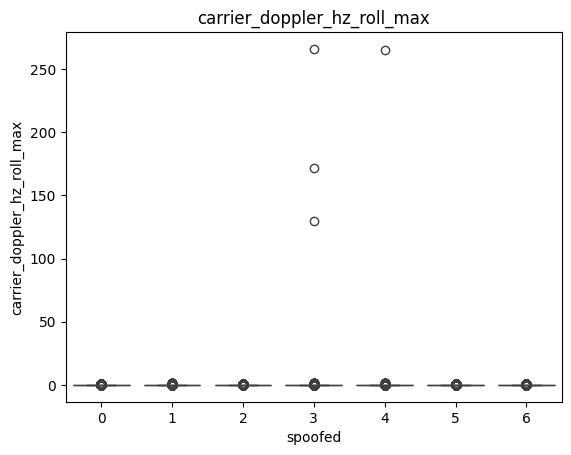

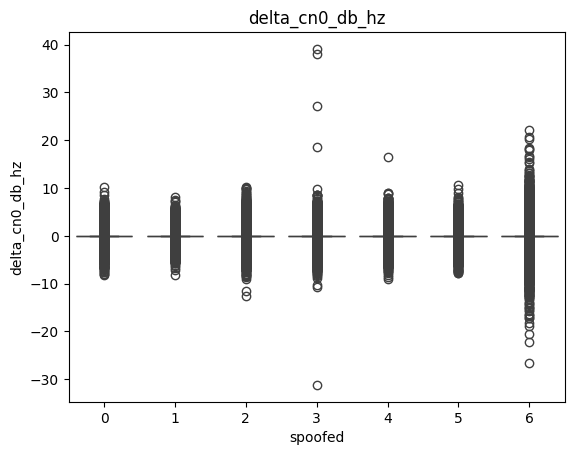

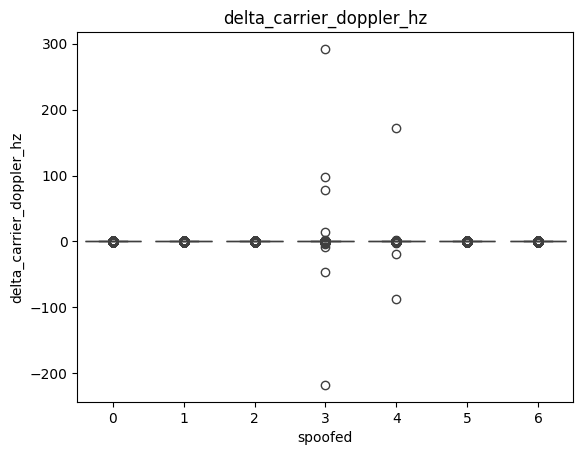

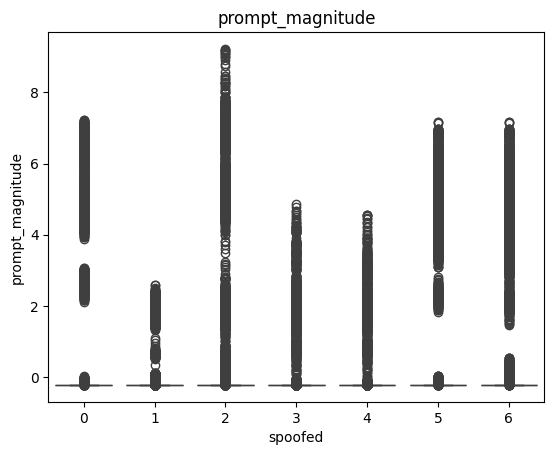

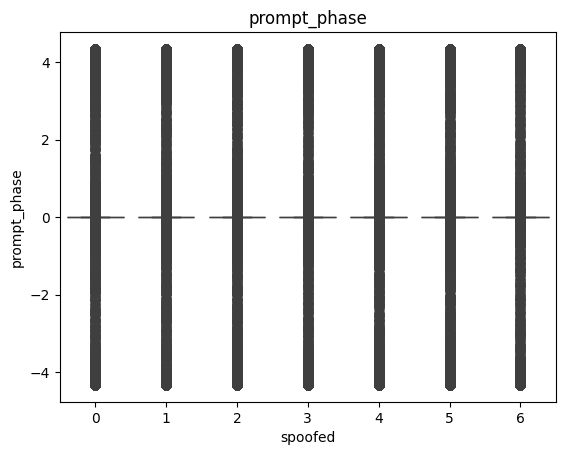

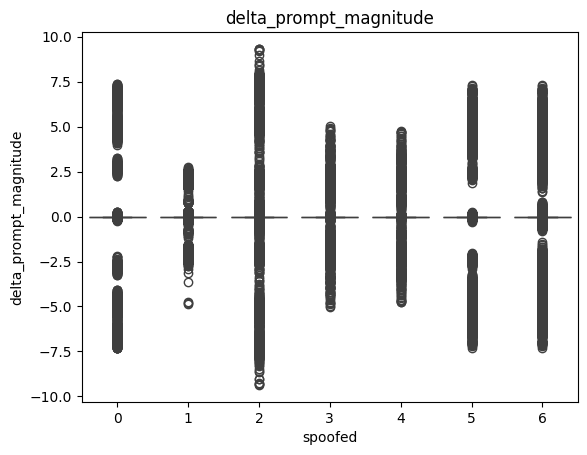

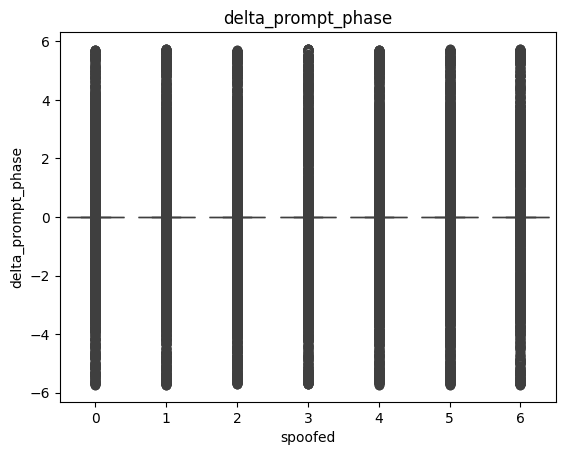

In [173]:
for col in X.columns:
    sns.boxplot(x=y, y=X[col])
    plt.title(col)
    plt.show()

In [174]:
svm = SVC(kernel='rbf', C=1.0, class_weight='balanced')
svm.fit(X_train, y_train)


SVC(class_weight='balanced')

In [175]:
svm_no_diff = SVC(kernel='rbf', C=1.0, class_weight='balanced')
svm_no_diff.fit(X_train_no_diff, y_train_no_diff)


SVC(class_weight='balanced')

In [176]:
y_pred = svm.predict(X_test)


In [177]:
y_pred_no_diff = svm_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.37      0.05      0.09      5213
           1       0.68      0.10      0.17      5525
           2       0.55      0.04      0.07      5403
           3       0.35      0.05      0.09      5265
           4       0.15      0.93      0.25      5406
           5       0.42      0.05      0.09      5522
           6       0.60      0.05      0.10      5519

    accuracy                           0.18     37853
   macro avg       0.44      0.18      0.12     37853
weighted avg       0.45      0.18      0.12     37853



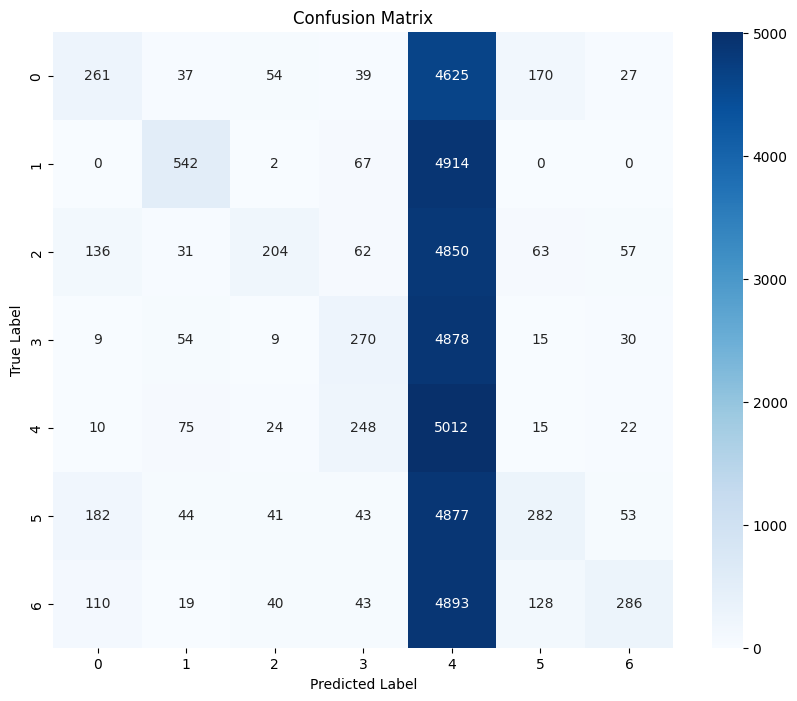

In [178]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.35      0.08      0.13      5225
           1       0.16      0.96      0.28      5454
           2       0.51      0.04      0.07      5426
           3       0.33      0.09      0.14      5213
           4       0.31      0.05      0.09      5399
           5       0.39      0.06      0.11      5555
           6       0.53      0.08      0.14      5581

    accuracy                           0.20     37853
   macro avg       0.37      0.20      0.14     37853
weighted avg       0.37      0.20      0.14     37853



Text(95.72222222222221, 0.5, 'True Label')

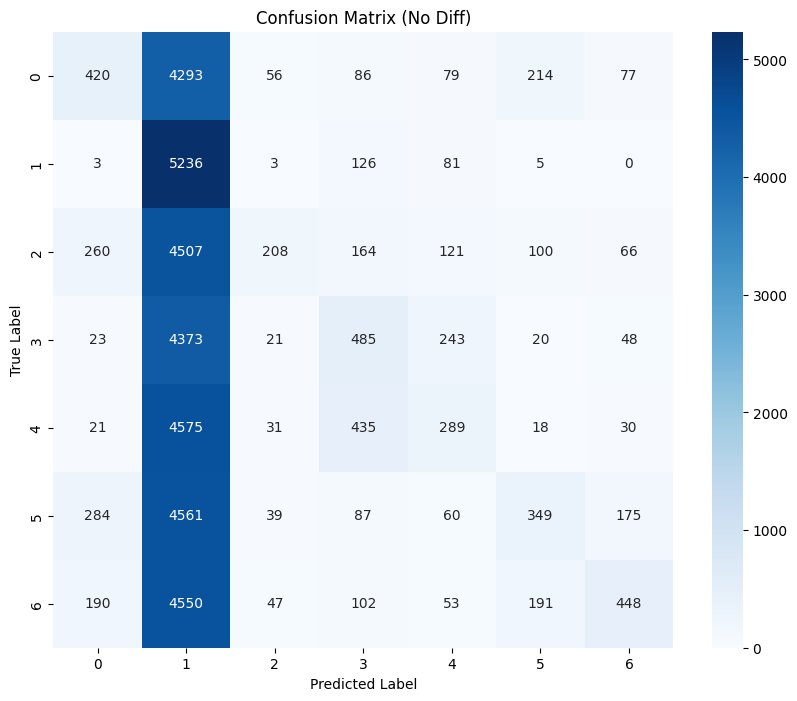

In [179]:
print(classification_report(y_test_no_diff, y_pred_no_diff))
cm_no_diff = confusion_matrix(y_test_no_diff, y_pred_no_diff)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_no_diff, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (No Diff)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [180]:
#random forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
rf_model.fit(X_train, y_train)

rf_model_no_diff = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
rf_model_no_diff.fit(X_train_no_diff, y_train_no_diff)

print("Random Forest")

importances = rf_model.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

print("\nRandom Forest No Diff")

importances = rf_model_no_diff.feature_importances_
features = X_train.columns  # assuming 'spoofed' is last
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.4f}")

Random Forest
prompt_i: 0.0631
prompt_q: 0.0682
cn0_db_hz: 0.0300
carrier_doppler_hz: 0.0291
rx_time: 0.0011
cn0_db_hz_roll_mean: 0.0428
cn0_db_hz_roll_std: 0.0840
cn0_db_hz_roll_min: 0.0600
cn0_db_hz_roll_max: 0.0698
carrier_doppler_hz_roll_mean: 0.0469
carrier_doppler_hz_roll_std: 0.0590
carrier_doppler_hz_roll_min: 0.0607
carrier_doppler_hz_roll_max: 0.0561
delta_cn0_db_hz: 0.0295
delta_carrier_doppler_hz: 0.0290
prompt_magnitude: 0.1244
prompt_phase: 0.0339
delta_prompt_magnitude: 0.0820
delta_prompt_phase: 0.0304

Random Forest No Diff
prompt_i: 0.0279
prompt_q: 0.0306
cn0_db_hz: 0.0154
carrier_doppler_hz: 0.0151
rx_time: 0.0005
cn0_db_hz_roll_mean: 0.0542
cn0_db_hz_roll_std: 0.0158
cn0_db_hz_roll_min: 0.3295
cn0_db_hz_roll_max: 0.2329
carrier_doppler_hz_roll_mean: 0.0217
carrier_doppler_hz_roll_std: 0.0415
carrier_doppler_hz_roll_min: 0.0308
carrier_doppler_hz_roll_max: 0.0352
delta_cn0_db_hz: 0.0244
delta_carrier_doppler_hz: 0.0315
prompt_magnitude: 0.0321
prompt_phase: 0.0303
d

In [181]:
y_pred = rf_model.predict(X_test)
y_pred_no_diff = rf_model_no_diff.predict(X_test_no_diff)

              precision    recall  f1-score   support

           0       0.63      0.08      0.15      5213
           1       0.92      0.10      0.18      5525
           2       0.75      0.08      0.15      5403
           3       0.65      0.09      0.15      5265
           4       0.15      0.97      0.27      5406
           5       0.55      0.07      0.13      5522
           6       0.71      0.07      0.12      5519

    accuracy                           0.21     37853
   macro avg       0.62      0.21      0.16     37853
weighted avg       0.62      0.21      0.16     37853



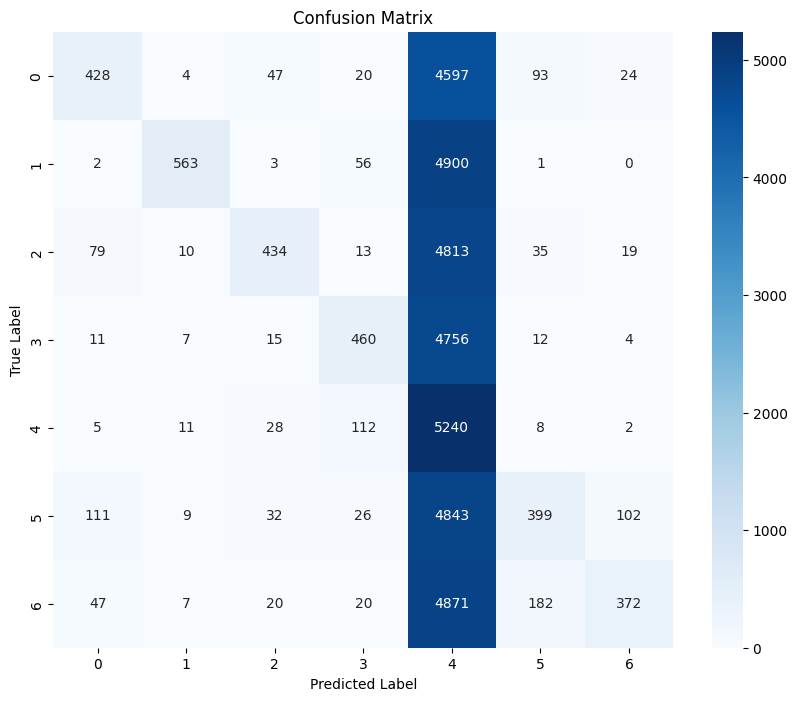

In [182]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

              precision    recall  f1-score   support

           0       0.63      0.08      0.15      5213
           1       0.92      0.10      0.18      5525
           2       0.75      0.08      0.15      5403
           3       0.65      0.09      0.15      5265
           4       0.15      0.97      0.27      5406
           5       0.55      0.07      0.13      5522
           6       0.71      0.07      0.12      5519

    accuracy                           0.21     37853
   macro avg       0.62      0.21      0.16     37853
weighted avg       0.62      0.21      0.16     37853



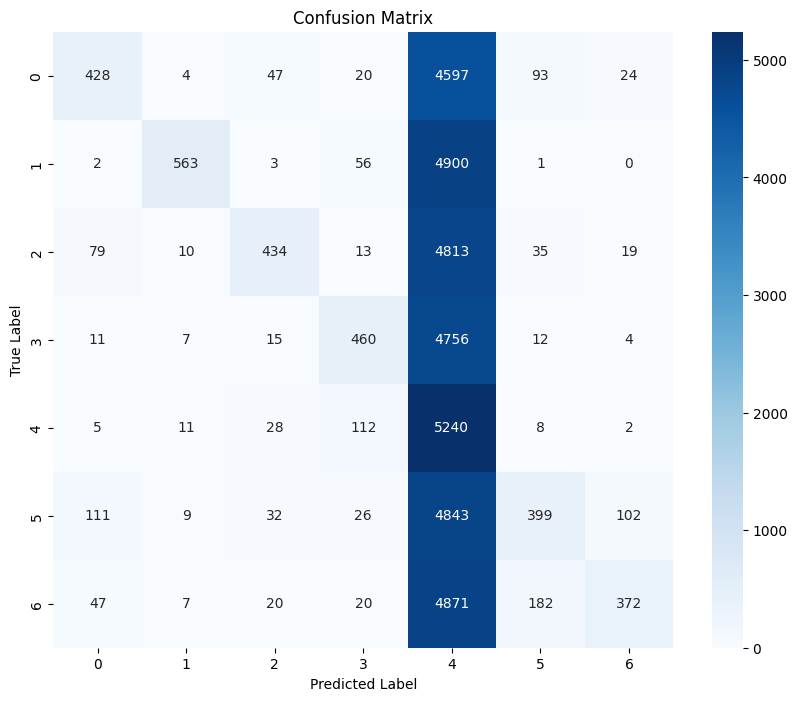

In [183]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

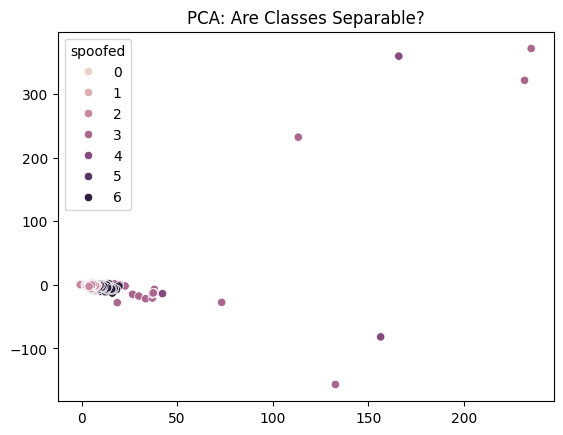

In [184]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y)
plt.title("PCA: Are Classes Separable?")
plt.show()
